# Using dask distributed cluster to speed up computation of PV potential by factor of 10

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from dask.distributed import Client
import core as core

import warnings
warnings.filterwarnings("ignore")


In [2]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

Start dask cluster with 10 processes (workers), each with 5 threads. 

In [4]:
years = [2000]
months = range(1, 12+1)
files = []

files = [f"era5-{year}-{month:02}.nc" for year in years for month in months]

files_path = [path+f for f in files]

print(f"Load data for {years=} {months=}")
files_path

Load data for years=[2000] months=range(1, 13)


['~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-01.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-02.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-03.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-04.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-05.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-07.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-08.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-09.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-10.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-11.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-12.nc']

In [8]:
ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )

In [5]:
ds_eu = ds.sel(latitude=slice(70,35))
# ds_eu = ds_eu.sel(longitude=slice(0,30))
ds
# ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')

ds=xr.open_mfdataset(path+"era5-2000-*.nc", engine="h5netcdf", chunks={"valid_time":1e5} )
ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
ds_1['longitude'] = ds_1['longitude'] - 360
ds_eu

NameError: name 'ds' is not defined

In [6]:
from dask.distributed import progress

from pathlib import Path
home = Path.home()
dask_workspace = home / "daskWorkspace"

# Using Dask Client as a context manager
with Client(n_workers=20, threads_per_worker=4, local_directory=dask_workspace) as client:
    print(client)
    start_time = time.time()
    ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )
    # ds=xr.open_mfdataset(files_path, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)

    ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
    ds_1['longitude'] = ds_1['longitude'] - 360

    ds_2 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(0,30))

    ds_eu = xr.concat([ds_1, ds_2], dim="longitude")
    
    # ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')
    # pvpot = core.pv_pot(ds).groupby(ds.valid_time.dt.month).mean("valid_time").persist()
    pvpot = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean("valid_time").compute()
    # progress(pvpot)
    # pvpot.compute()
    
    # pvpot = core.pv_pot(ds).mean("valid_time").compute()
    end_time = time.time()
    execution_time = end_time - start_time
print(f"Execution time: {execution_time:.5f} seconds")

<Client: 'tcp://127.0.0.1:33069' processes=20 threads=80, memory=753.83 GiB>
Execution time: 20.48173 seconds


In [31]:
ds_eu

<xarray.Dataset> Size: 590MB
Dimensions:     (valid_time: 1440, latitude: 141, longitude: 121)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 12kB 2000-01-01 ... 2000-02-29T23...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 968B 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 23kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 98MB dask.array<chunksize=(744, 41, 121), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
ds_eu.

In [7]:
print(f"{pvpot.shape}")
pvpot

(12, 141, 161)


<xarray.DataArray (month: 12, latitude: 141, longitude: 161)> Size: 1MB
array([[[0.00031222, 0.00031471, 0.00031644, ..., 0.00029615,
         0.00029874, 0.00029938],
        [0.00039874, 0.00040131, 0.00040305, ..., 0.00038027,
         0.00038839, 0.00037046],
        [0.00050565, 0.0005067 , 0.00050641, ..., 0.00046286,
         0.0004429 , 0.00042279],
        ...,
        [0.12258013, 0.12240249, 0.12198541, ..., 0.12548393,
         0.12480054, 0.12452262],
        [0.12356924, 0.12347526, 0.1234018 , ..., 0.12480268,
         0.12513228, 0.12538747],
        [0.1241347 , 0.12420183, 0.12458853, ..., 0.12378363,
         0.12454746, 0.12511471]],

       [[0.0105205 , 0.01057357, 0.0106173 , ..., 0.0169311 ,
         0.01727965, 0.01757862],
        [0.01142124, 0.01147519, 0.01151889, ..., 0.01766135,
         0.01816615, 0.01799657],
        [0.01234029, 0.01246668, 0.01257798, ..., 0.01763046,
         0.01740202, 0.01717888],
...
        [0.11403787, 0.11487817, 0.1160351 , ..., 0.13246123,
         0.13242367, 0.1321558 ],
        [0.11654919, 0.11736603, 0.11836936, ..., 0.1339718 ,
         0.1342102 , 0.13418214],
        [0.11861699, 0.11973772, 0.12082005, ..., 0.13522069,
         0.13553207, 0.1356868 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.09688222, 0.09769657, 0.09825681, ..., 0.10826907,
         0.10719693, 0.10677325],
        [0.09899655, 0.09974837, 0.10015008, ..., 0.11054727,
         0.10953443, 0.10910401],
        [0.10114095, 0.10154781, 0.10180193, ..., 0.11295395,
         0.11187823, 0.11105206]]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

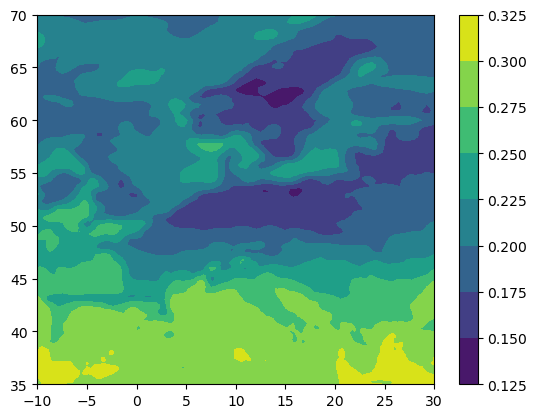

In [11]:
plt.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[6])
plt.colorbar()

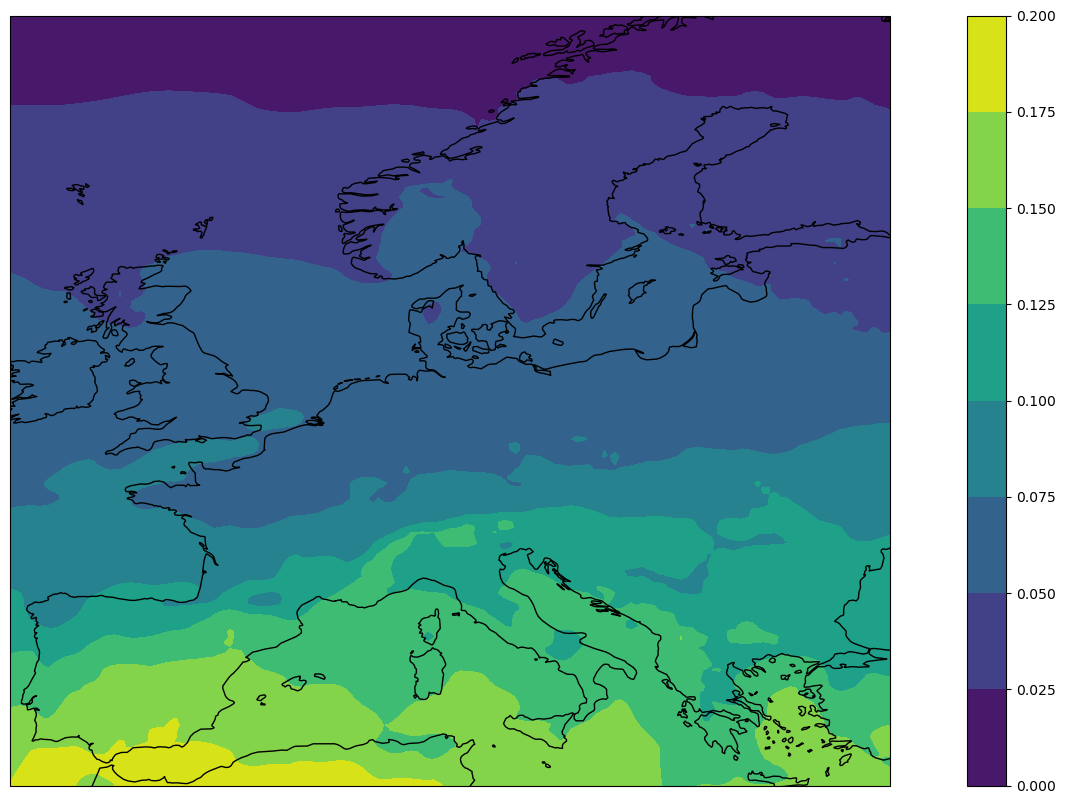

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a figure with a specified projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
# ax.add_feature(cfeature.LAND)

# Create contour plot
contour = ax.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[1])

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)

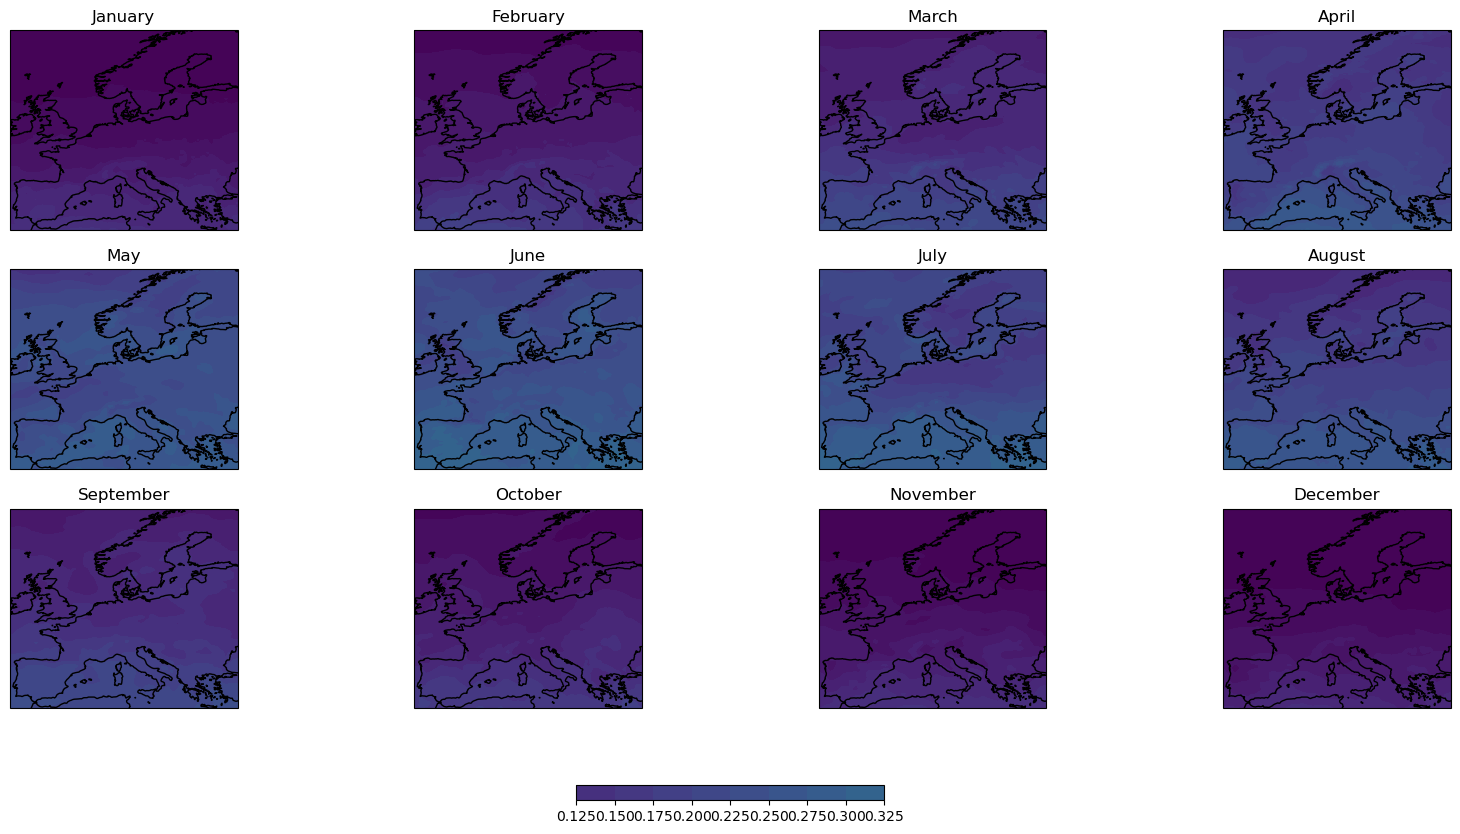

In [20]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
axs = axs.flatten()
contours = []
for m in range(len(pvpot)):
    axs[m].add_feature(cfeature.COASTLINE)
    
    
    contour = axs[m].contourf(pvpot[m].longitude, pvpot[m].latitude, pvpot[m], vmin=0, vmax=1)
    axs[m].set_title(f"{calendar.month_name[m+1]}")
    contours.append(contour)
    # axs[m].colorbar(contour, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
cbar = fig.colorbar(contours[6], ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)


In [46]:
import geopandas as gpd

# Load a world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Europe
europe = world[world['continent'] == 'Europe']

# Get the geometry of Europe
coordinates = europe.geometry


In [59]:
import xarray as xr
import geopandas as gpd
import numpy as np

# Load your xarray dataset
# ds = xr.open_dataset('your_dataset.nc')

# Example: create a dummy dataset with the specified dimensions
lat = np.linspace(-90, 90, 721)  # 721 latitudes from -90 to 90
lon = np.linspace(-180, 180, 1440)  # 1440 longitudes from -180 to 180
data = np.random.rand(len(lat), len(lon))  # Dummy data
ds = xr.DataArray(data, coords=[lat, lon], dims=['latitude', 'longitude'])

# Load the European boundary (replace with your own source)
europe_boundaries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = europe_boundaries[europe_boundaries['continent'] == 'Europe']

# Create a polygon for Europe
europe_polygon = europe.geometry.unary_union

# Create a mask for the European region
# Create a meshgrid of latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Flatten the grid for processing
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Create points and check if they are in the polygon
points = gpd.points_from_xy(lon_flat, lat_flat)
mask_flat = np.array([europe_polygon.contains(point) for point in points])

# Reshape the mask to match the dimensions of the dataset
mask = mask_flat.reshape(len(lat), len(lon))

# Filter the dataset
filtered_ds = ds.where(mask)

# The filtered_ds will contain NaNs for cells outside Europe
print(filtered_ds)


<xarray.DataArray (latitude: 721, longitude: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 12kB -180.0 -179.7 -179.5 ... 179.7 180.0


In [1]:
ds.sel(latitude=slice(0,90))

NameError: name 'ds' is not defined

In [ ]:
# Climatological mean?
# Energy need changes per season, pv per month, maybe satisfy just january
# Enough energy potential to handle spikes? 

# Be clear with which energy need, start with year mean maybe then get more complex